# Simple NN with Keras

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import sys
sys.path.append('/Users/kaonpark/workspace/github.com/likejazz/kaon-learn')
import kaonlearn
from kaonlearn.plots import plot_decision_regions, plot_history

In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
np.random.seed(1671) # for reproducibility

# network and training
NB_CLASSES = 10 # number of outputs = number of digits
VALIDATION_SPLIT=0.2 # how much TRAIN is reserved for VALIDATION

# data: shuffled and split between train and test sets
#
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# X_train is 60000 rows of 28x28 values --> reshaped in 60000 x 784
RESHAPED = 784
#
X_train = X_train.reshape(60000, RESHAPED)
X_test = X_test.reshape(10000, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize
#
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, NB_CLASSES)
Y_test = np_utils.to_categorical(y_test, NB_CLASSES)

# 10 outputs
# final stage is softmax

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(RESHAPED,)))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

Using TensorFlow backend.


60000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [3]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0001, 
                               patience=0, verbose=0, mode='auto')

In [4]:
from keras_tqdm import TQDMNotebookCallback
history = model.fit(X_train, Y_train,
                    batch_size=128, epochs=100,
                    verbose=0, validation_split=VALIDATION_SPLIT,
                    callbacks=[TQDMNotebookCallback(show_inner=False), early_stopping])

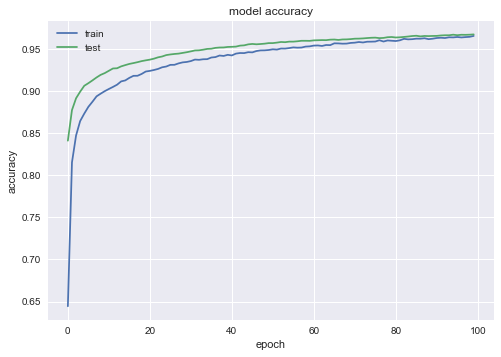

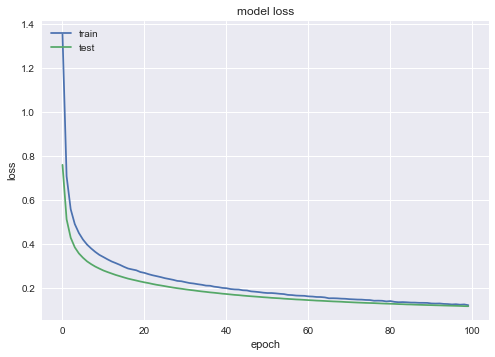

In [5]:
plot_history(history)

In [6]:
score = model.evaluate(X_test, Y_test)
score[1] # accuracy

 9952/10000 [============================>.] - ETA: 0s

0.96689999999999998

In [7]:
# calculate predictions
score = model.predict_proba(X_test)
score

 9216/10000 [==========================>...] - ETA: 0s

array([[  4.48437868e-06,   9.66792527e-07,   1.89313520e-04, ...,
          9.97638941e-01,   8.98177223e-06,   1.42340155e-04],
       [  3.29340663e-04,   3.13051511e-04,   9.95687783e-01, ...,
          2.58626343e-09,   7.66543788e-04,   1.30803794e-08],
       [  5.58545253e-05,   9.88885999e-01,   2.30457098e-03, ...,
          5.12512075e-03,   1.25841843e-03,   8.55742474e-05],
       ..., 
       [  1.26822028e-08,   2.87829618e-08,   2.37851779e-07, ...,
          3.50033188e-05,   1.19830991e-04,   1.07374077e-03],
       [  1.16475594e-05,   8.92977405e-05,   3.10790460e-06, ...,
          2.09497080e-06,   1.61905959e-03,   3.80714880e-07],
       [  1.70582534e-05,   1.57292899e-08,   1.66575934e-04, ...,
          3.01950323e-08,   7.62572927e-06,   2.40744544e-08]], dtype=float32)

# word2vec skip-grams model

In [8]:
from keras.preprocessing.text import *
from keras.preprocessing.sequence import skipgrams

text = "I love green eggs and ham ."

tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

wids = [word2id[w] for w in text_to_word_sequence(text)]
pairs, labels = skipgrams(wids, len(word2id))
print(len(pairs), len(labels))
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
        id2word[pairs[i][0]], pairs[i][0], 
        id2word[pairs[i][1]], pairs[i][1],
        labels[i]))

56 56
(ham (6), love (2)) -> 1
(love (2), ham (6)) -> 1
(eggs (4), ham (6)) -> 1
(ham (6), and (5)) -> 0
(love (2), green (3)) -> 0
(eggs (4), green (3)) -> 1
(and (5), love (2)) -> 1
(green (3), i (1)) -> 0
(eggs (4), love (2)) -> 1
(and (5), i (1)) -> 1


In [9]:
len(word2id)

6

In [10]:
wids

[1, 2, 3, 4, 5, 6]

In [11]:
word2id

{'and': 5, 'eggs': 4, 'green': 3, 'ham': 6, 'i': 1, 'love': 2}

In [12]:
pairs, labels = skipgrams([1,2,3,4,5,6,7,8,9,10], 10, shuffle=False)

In [13]:
len(pairs)

120

In [14]:
for i in range(10):
    print(pairs[i], labels[i])

[1, 2] 1
[1, 3] 1
[1, 4] 1
[1, 5] 1
[2, 1] 1
[2, 3] 1
[2, 4] 1
[2, 5] 1
[2, 6] 1
[3, 1] 1


Keras의 `skipgrams` 함수는 word2vec 논문의 skip-grams 모델을 지원한다. context words인 경우 positive를 반환하는데, 함수의 인자값으로 negative_samples를 부여하면(default: 1)는 positive samples 배수만큼 단어를 랜덤 샘플링하여 negative로 정의한다. 즉, 디폴트는 1이므로 1:1로 positive, negative를 구성한다. 문장이 짧을때는 context words가 negative인 경우도 발생하는데 일종의 버그로 보인다. 그러나 문장이 길 경우에는 랜덤 샘플링으로 인해 context words가 negative로 정의될 가능성은 매우 낮다.

참고: word2vec은 예측 모델이고 GloVe는 카운트 기반 모델이다.

# word2vec with Keras

In [15]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer, one_hot
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import nltk
import operator

np.random.seed(42)

lines = []
fin = open("data/alice_in_wonderland.txt", "r")
for line in fin:
    line = line.strip()
    if len(line) == 0:
        continue
    lines.append(line)
fin.close()

sents = nltk.sent_tokenize(" ".join(lines))
len(sents)

1616

In [16]:
tokenizer = Tokenizer(5000)  # use top 5000 words only
tokens = tokenizer.fit_on_texts(sents)
vocab_size = len(tokenizer.word_counts) + 1
tokens, vocab_size

(None, 2647)

In [17]:
xs = []
ys = []
for sent in sents: # 한 문장씩 진행
    embedding = one_hot(sent, vocab_size)
    triples = list(nltk.trigrams(embedding))
    w_lefts = [x[0] for x in triples]
    w_centers = [x[1] for x in triples]
    w_rights = [x[2] for x in triples]
    xs.extend(w_centers)
    ys.extend(w_lefts)
    xs.extend(w_centers)
    ys.extend(w_rights)

len(xs), len(ys), xs[0], ys[0]

(49150, 49150, 385, 25)

In [18]:
ohe = OneHotEncoder(n_values=vocab_size)
X = ohe.fit_transform(np.array(xs).reshape(-1, 1)).todense()
Y = ohe.fit_transform(np.array(ys).reshape(-1, 1)).todense()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,
                                                random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34405, 2647), (14745, 2647), (34405, 2647), (14745, 2647))

49,150번의 단어가 등장하고 단어의 수는 2,647개이다.

In [19]:
X_train[0] # ont-hot vector

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [20]:
model = Sequential()
model.add(Dense(300, input_shape=(X_train.shape[1],)))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1]))
model.add(Activation("softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 300)               794400    
_________________________________________________________________
activation_1 (Activation)    (None, 300)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2647)              796747    
_________________________________________________________________
activation_2 (Activation)    (None, 2647)              0         
Total params: 1,591,147
Trainable params: 1,591,147
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train, y_train, batch_size=128,
                    epochs=50, verbose=0,
                    validation_split=0.2,
                    callbacks=[TQDMNotebookCallback(show_inner=False)])

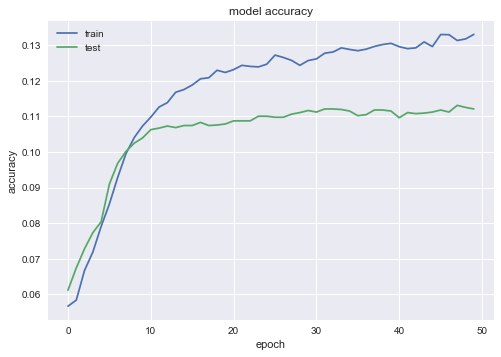

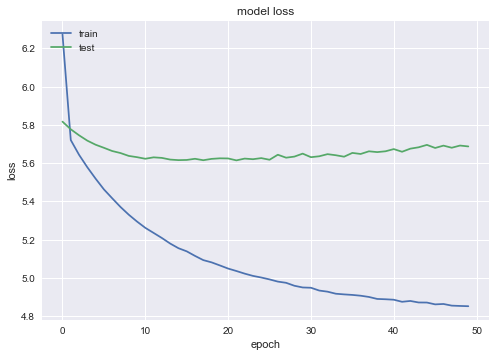

In [22]:
plot_history(history)

In [23]:
# evaluate model
score = model.evaluate(X_test, y_test, verbose=1)
score[1]

14720/14745 [============================>.] - ETA: 0s

0.11319091216755463

In [24]:
# using the word2vec model
word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}

# retrieve the weights from the first dense layer. This will convert
# the input vector from a one-hot sum of two words to a dense 300
# dimensional representation
W, b = model.layers[0].get_weights()

idx2emb = {}
for word in word2idx.keys():
    wid = word2idx[word]
    vec_in = ohe.fit_transform(np.array(wid)).todense()
    vec_emb = np.dot(vec_in, W)
    idx2emb[wid] = vec_emb

In [25]:
idx2word[1], idx2emb[1].shape, word2idx['the'], len(word2idx)

('the', (1, 300), 1, 2646)

In [26]:
trained_embeddings = np.zeros((5000, 300))

for k in idx2emb.keys():
    trained_embeddings[k] = idx2emb[k]

In [27]:
trained_embeddings.shape

(5000, 300)

In [28]:
for word in ["stupid", "alice", "succeeded"]:
    wid = word2idx[word]
    source_emb = idx2emb[wid]
    distances = []
    for i in range(1, vocab_size):
        if i == wid:
            continue
        target_emb = idx2emb[i]
        distances.append(((wid, i),
                         cosine_distances(source_emb, target_emb)))
    sorted_distances = sorted(distances, key=operator.itemgetter(1))[0:10]
    predictions = [idx2word[x[0][1]] for x in sorted_distances]
    print("{:s} => {:s}".format(word, ", ".join(predictions)))

stupid => front, answered, squeaking, hedgehogs, brush, eyelids, this, suppressed, leaders, breathe
alice => flamingoes, anger, solemnly, chains, scolded, milk, breeze, give, box, pity
succeeded => panted, advance, lad, pinched, mistake, happy, flapper, straightening, remedies, set


In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=10000, verbose=1)
plot_only = 50
low_dim_embs = tsne.fit_transform(trained_embeddings[:plot_only, :])
count = 0

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 0.566745
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.752465
[t-SNE] Error after 125 iterations: 0.752465


In [30]:
low_dim_embs.shape

(50, 2)

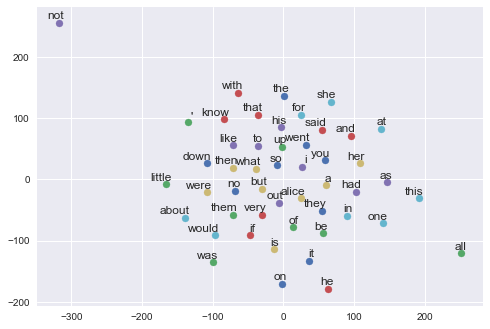

In [31]:
for k in idx2word.keys():
    count += 1
    if count == plot_only:
        break
    x, y = low_dim_embs[k, :]
    plt.scatter(x, y)
    plt.annotate(idx2word[k],
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

plt.show()

# word2vec basic with Tensorflow

In [32]:
# Inspired by https://www.tensorflow.org/versions/r0.7/tutorials/word2vec/index.html
import collections
import tensorflow as tf

from six.moves import xrange 

# Configuration
batch_size = 20
# Dimension of the embedding vector.
embedding_size = 10
num_sampled = 15    # Number of negative examples to sample.

# Sample sentences
sentences = ["the quick brown fox jumped over the lazy dog",
            "I love cats and dogs",
            "we all love cats and dogs",
            "cats and dogs are great",
            "sung likes cats",
            "she loves dogs",
            "cats can be very independent",
            "cats are great companions when they want to be",
            "cats are playful",
            "cats are natural hunters",
            "It's raining cats and dogs",
            "dogs and cats love sung"]

# sentences to words and count
words = " ".join(sentences).split()
count = collections.Counter(words).most_common()
# print ("Word count", count[:5])

# Build dictionaries
rdic = [i[0] for i in count] #reverse dic, idx -> word
dic = {w: i for i, w in enumerate(rdic)} #dic, word -> id
voc_size = len(dic)

# Make indexed word data
data = [dic[word] for word in words]
# print('Sample data', data[:10], [rdic[t] for t in data[:10]])

# Let's make a training data for window size 1 for simplicity
# ([the, brown], quick), ([quick, fox], brown), ([brown, jumped], fox), ...
cbow_pairs = [];
for i in range(1, len(data)-1) :
    cbow_pairs.append([[data[i-1], data[i+1]], data[i]]);
# print('Context pairs', cbow_pairs[:10])

# Let's make skip-gram pairs
# (quick, the), (quick, brown), (brown, quick), (brown, fox), ...
skip_gram_pairs = [];
for c in cbow_pairs:
    skip_gram_pairs.append([c[1], c[0][0]])
    skip_gram_pairs.append([c[1], c[0][1]])
# print('skip-gram pairs', skip_gram_pairs[:5])

def generate_batch(size):
    assert size < len(skip_gram_pairs)
    x_data=[]
    y_data = []
    r = np.random.choice(range(len(skip_gram_pairs)), size, replace=False)
    for i in r:
        x_data.append(skip_gram_pairs[i][0])  # n dim
        y_data.append([skip_gram_pairs[i][1]])  # n, 1 dim
    return x_data, y_data

# generate_batch test
# print ('Batches (x, y)', generate_batch(3))

# Input data
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
# need to shape [batch_size, 1] for nn.nce_loss
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
# Ops and variables pinned to the CPU because of missing GPU implementation
with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs) # lookup table

# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.random_uniform([voc_size, embedding_size],-1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# Compute the average NCE loss for the batch.
# This does the magic:
#   tf.nn.nce_loss(weights, biases, inputs, labels, num_sampled, num_classes ...)
# It automatically draws negative samples when we evaluate the loss.
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, num_sampled, voc_size))

# Use the adam optimizer
train_op = tf.train.AdamOptimizer(1e-1).minimize(loss)

# Launch the graph in a session
with tf.Session() as sess:
    # Initializing all variables
    tf.global_variables_initializer().run()

    for step in range(100):
        batch_inputs, batch_labels = generate_batch(batch_size)
        _, loss_val = sess.run([train_op, loss],
                feed_dict={train_inputs: batch_inputs, train_labels: batch_labels})

    # Final embeddings are ready for you to use. Need to normalize for practical use
    trained_embeddings = embeddings.eval()

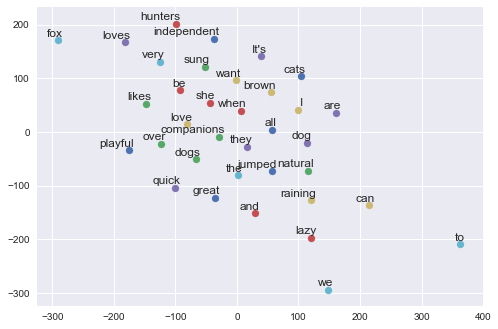

In [33]:
from sklearn.manifold import TSNE

# 기존 샘플은 그래프로 표현하기 위해 embedding_size=2로 설정하여 임베딩을 의미있게 표현하기 힘들었다.
# 여기서는 충분한 차원으로 임베딩하고 t-SNE로 차원축소하여 표현한다.
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=10000)
plot_only = 50
low_dim_embs = tsne.fit_transform(trained_embeddings[:plot_only, :])
labels = rdic[:plot_only]

assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

plt.show()

t-SNE의 결과는 PCA와는 달리 지나치게 랜덤하게 변하는 특징이 있다.